# PyTorch Custom Datasets

PyTorch has many built-in datasets used for a wide number of machine learning benchmarks, however, you'll often want to use your own custom dataset.

A custom dataset is a collection of data relating to a specific problem you're working on.
In essence, a custom dataset can be comprised of almost anything (맞춤형 데이터셋은 거의 어떤 형태로든 구성 가능함)

PyTorch includes many existing functions to load in various custom datasets in the TorchVision, TorchText, TorchAudio and TorchRec domain libraries
But sometimes these existing functions may not be enough
In that case, we can always subclass torch.utils.data.Dataset and customize it to our liking (torch.utils.data.Dataset을 상속하여 원하는 방식으로 커스터마이징 가능)

0. Importing PyTorch and setting up device-agnostic code
1. Get data

2. Become one with the data (data preparation)
 - At the beginning of any new machine learning problem, it's paramount to understand the data you're working with. Here we'll take some steps to figure out what data we have

3. Transforming data 
 - Often, the data you get won't be 100% ready to use with a machine learning model, here we'll look at some steps we can take to transform our images so they're ready to be used with a model  
 (대부분의 경우, 데이터를 바로 모델에 사용할 수 없음, 여기서 이미지를 모델에 맞게 변환하는 방법을 배움)

4. Loading data with ImageFolder(option 1)
 - PyTorch has many in-built data loading functions for common types of data. ImageFolder is helpful if our images are in standard image classification format
 (PyTorch에는 일반적인 데이터 형식에 맞는 데이터 로딩 함수들이 내장되어 있음, 이미지가 일반적인 분류 구조라면 ImageFolder를 사용하는 것이 유용함)

5. Loading image data with a custom Dataset
 - What if PyTorch didn't have an in-built function to load data with? This is where we can build our own custom subclass of torch.utils.data.Dataset
 (PyTorch에 해당 데이터를 불러올 수 있는 내장 함수가 없을 때는 torch.utils.data.Dataset을 상속받아 직접 사용자 정의 데이터셋 클래스를 만들 수 있음)

6. Other forms of transforms (data augmentation(증강))
 - Data augmentation is a common technique for expanding the diversity of your training data. Here we'll explore some of torchvision's in-built data augmentation functions.
 (데이터 증강은 훈련 데이터의 다양성을 높이기 위한 일반적인 기법임)

7. Model 0: TinyVGG without data augmentation 
 - By this stage, we'll have our data ready, build a model capable of fitting it, also create some training and testing functions for training and evaluating our model

8. Exploring loss curves 
 - Loss curves are a great way to see how your model is training/improving over time. They're also a good way to see if model is uderfitiing(과소적합) or overfitting

9. Model 1: TinyVGG with data augmentation

10. Compare model results

11. Making a prediction on a custom image

In [2]:
# Importing PyTorch and setting up device-agnostic code
import torch
from torch import nn

print(torch.__version__)

device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

2.7.1+cu126
cuda


In [4]:
# Get data

# Machine learning is an iterative process, start small, get something working and increase when necessary
# formatted data (전처리된 데이터)

# The dataset we're about to use has been pre-formatted for what we'd like to use it for
# However, you'll often have to format your own datasets for whatever problem you're working on. 
# This is a regular practice in the machine learning world  (실제 머신러닝 작업에서는 대부분 직접 데이터셋을 전처리해야함, 머신러닝 분야에서 일상적인 작업임)

import requests
import zipfile  # 압축 파일(zip)의 압축을 푸는 데 사용
from pathlib import Path

data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi"

if image_path.is_dir():  # image_path 디렉토리가 이미 존재하는지 확인
    print(f"{image_path} directory exists.")
else:
    print(f"Did not find {image_path} directory, creating one...")
    image_path.mkdir(parents=True, exist_ok=True) # parents=True : 상위 디렉토리(data/)도 없으면 자동 생성, exist_ok=True : 이미 존재해도 에러 발생하지 않음

    with open(data_path / "pizza_steak_sushi.zip", "wb") as f:
        request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
        print("Downloading pizza, steak, sushi data...")
        f.write(request.content) # open()으로 열어둔 파일 객체 f에 대해 request.content를 바이너리로 저장
    
    # Unzip (압축해제)
    with zipfile.ZipFile(data_path / "pizza_steak_sushi.zip", "r") as zip_ref:  # .ZipFile() : ZipFile 객체를 생성 (.zip 파일을 열기 위한 도구, 이 객체를 통해 압축 해제, 파일 목록 조회 등의 작업을 할 수 있음)
        print("Unzipping pizza, steak, sushi data...")
        zip_ref.extractall(image_path)  # extractall(image_path) : image_path 폴더(data/pizza_steak_sushi)에 압축 내용 모두 풀기 (.ZipFile()로 연 zip 파일 객체에 대해 모든 파일을 한 번에 압축 해제하는 메서드)

data\pizza_steak_sushi directory exists.


In [6]:
# Data preparation

# Before starting a project or building any kind of model, it's important to know what data working with
# image classification format : Contains separate classes of images in separate directories titled with a particular class name
# (이미지 분류 포맷이란, 각 클래스별 이미지가 각각의 폴더에 저장되어 있는 구조, 각 폴더는 해당 클래스의 이름을 폴더명으로 가짐)
# This format is popular across many different image classification benchmarks

# Find a way to best turn data into a dataset compatible with PyTorch (PyTorch와 호환되는 형식으로 변환할 최적의 방법을 찾아야함)

# We can inspect what's in our data directory by writing a small helper function to walk through each of the subdirectories and count the files present
# (데이터 디렉토리에 무엇이 들어 있는지 확인하려면, 각 하위 폴더를 순회하며 파일 개수를 세는 작은 보조 함수(helper function)를 작성함, os.walk())

import os
# Walks through dir_path returning its contents (os.walk()를 이용해 하위 폴더까지 모두 탐색함)
# os.walk() : 디렉토리 안을 반복하며, 각 위치에서 (dirpath, dirnames, filenames) 튜플을 순차적으로 반환 (현재 탐색 중인 폴더의 경로, dirpath 안에 있는 하위 폴더들의 이름 목록, dirpath 안에 있는 파일 이름들의 목록)
def walk_through_dir(dir_path):
    for dirpath, dirnames, filenames in os.walk(dir_path):
        print(f"There are {len(dirnames)} driectories and {len(filenames)} image in '{dirpath}")

In [12]:
print(walk_through_dir(image_path),"\n")

There are 2 driectories and 0 image in 'data\pizza_steak_sushi
There are 3 driectories and 0 image in 'data\pizza_steak_sushi\test
There are 0 driectories and 25 image in 'data\pizza_steak_sushi\test\pizza
There are 0 driectories and 19 image in 'data\pizza_steak_sushi\test\steak
There are 0 driectories and 31 image in 'data\pizza_steak_sushi\test\sushi
There are 3 driectories and 0 image in 'data\pizza_steak_sushi\train
There are 0 driectories and 78 image in 'data\pizza_steak_sushi\train\pizza
There are 0 driectories and 75 image in 'data\pizza_steak_sushi\train\steak
There are 0 driectories and 72 image in 'data\pizza_steak_sushi\train\sushi
None 



In [15]:
train_dir = image_path / "train"
test_dir = image_path / "test"

print(train_dir)
print(test_dir)

train_dir, test_dir

data\pizza_steak_sushi\train
data\pizza_steak_sushi\test


(WindowsPath('data/pizza_steak_sushi/train'),
 WindowsPath('data/pizza_steak_sushi/test'))

Random image path: data\pizza_steak_sushi\test\sushi\2394442.jpg
Image class: sushi
Image height: 408
Image width: 512


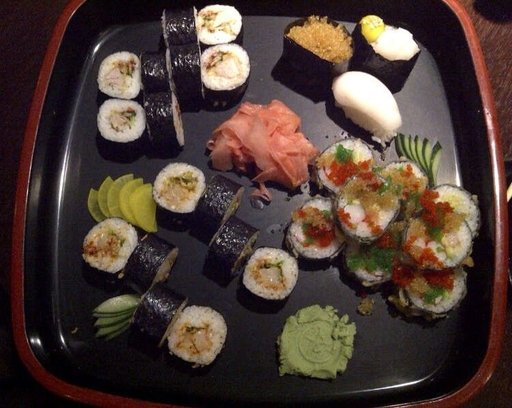

In [20]:
# Visualize an image

# 1. pathlib.Path.glob()를 사용해서 .jpg 확장자로 끝나는 모든 이미지 경로를 가져옴
# 2. Python의 random.choice()로 무작위 이미지 경로 선택
# 3. pathlib.Path.parent.stem을 사용해 선택한 이미지의 클래스 이름(class name) 얻기
# 4. Since we're working with images, open the random image path using PIL.Image.open() (PIL stands for Python Image Library)
# 5. Show the image and print some metadata

import random
from PIL import Image

random.seed(42)

image_path_list = list(image_path.glob("*/*/*.jpg"))

random_image_path = random.choice(image_path_list)

image_class = random_image_path.parent.stem

img = Image.open(random_image_path)

print(f"Random image path: {random_image_path}")
print(f"Image class: {image_class}")
print(f"Image height: {img.height}")
print(f"Image width: {img.width}")
img

(np.float64(-0.5), np.float64(511.5), np.float64(407.5), np.float64(-0.5))

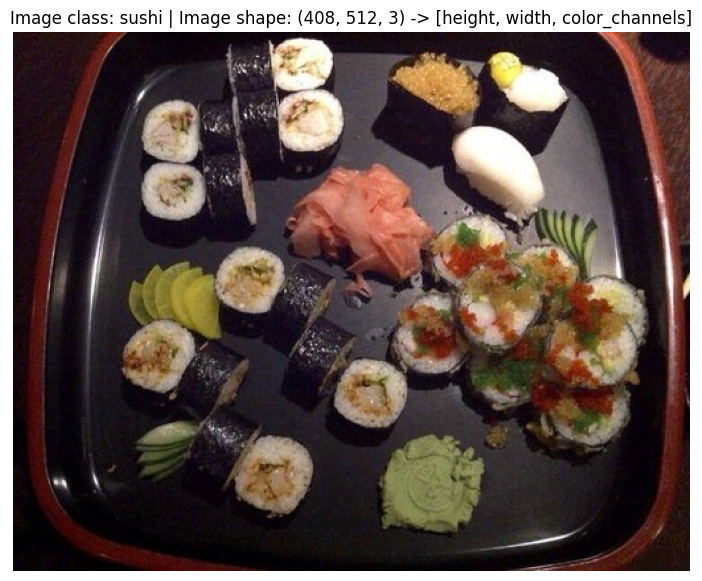

In [ ]:
# Do the same with matplotlib.pyplot.imshow()   (convert the image to a NumPy array first)
import numpy as np
import matplotlib.pyplot as plt

img_as_array = np.asarray(img)  # 다른 자료형을 NumPy배열로 변환

plt.figure(figsize=(10,7))
plt.imshow(img_as_array)
plt.title(f"Image class: {image_class} | Image shape: {img_as_array.shape} -> [height, width, color_channels]")
plt.axis(False)

# Transforming data

Turn image data into tensors (numerical representations of images)
Turn it into a torch.utils.data.Dataset and subsequently a torch.utils.data.DataLoader (call these Dataset and DataLoader for short)

1. Vision - torchvision.datasets
2. Audio - torchaudio.datasets
3. Text - torchtext.datasets
4. Recommendation system - torchrec.datasets


In [27]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

# Transforming data with torchvision.transforms

need to convert folders of images into tensors
One of the ways can do this is by using the vorchvision.transforms module
torchvision.transforms contains many pre-built methods for formatting images, turning them into tensors and even manipulating them for data augmentation
data augmentation : the practice of altering data to make it harder for a model to learn

1. Resize the images using transforms.Resize()
 + some models prefer images of different sizes and shapes

2. Flip our images randomly on the horizontal using transforms.RandomHorizontalFlip()  
 (transforms.RandomHorizontalFlip()을 사용하여 이미지를 좌우로 무작위 반전함)

3. Turn our images from a PIL image to a PyTorch tensor using transforms.ToTensor()

+ can compile all of these steps using torchvision.transforms.Compose()


Generally, the larger the shape of the image, the more information a model can recover (이미지의 크기가 클수록, 모델이 더 많은 정보를 얻을 수 있음)
The tradeoff is that more pixels requires more computations

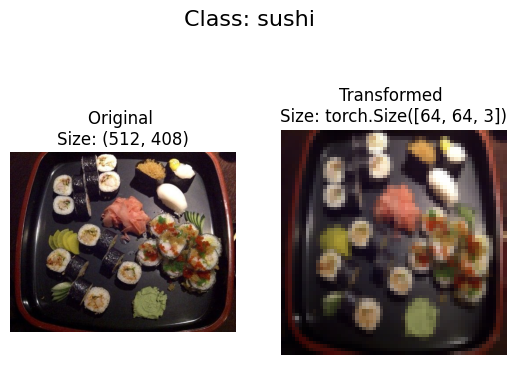

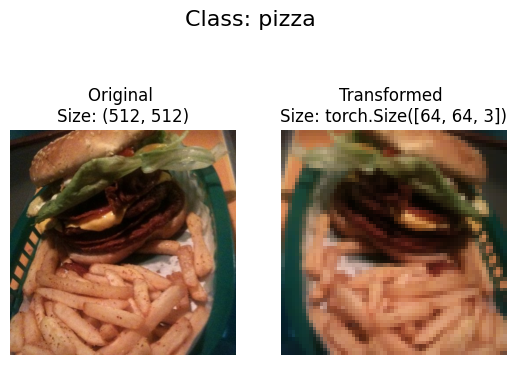

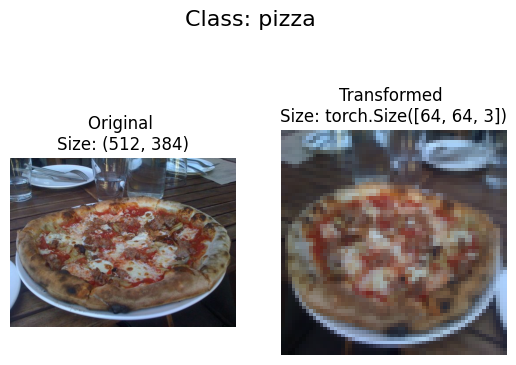

In [ ]:
data_transform = transforms.Compose([transforms.Resize(size=(64,64)),
                                     transforms.RandomHorizontalFlip(p=0.5),  # p = probability of flip, 0.5 = 50% chance
                                     transforms.ToTensor()])  # turn the image into a torch.Tensor
                                                              # this also converts all pixel values from 0 to 255 to be between 0.0 and 1.0 (모든 픽셀 값을 0에서 255 사이의 정수에서 0.0에서 1.0 사이의 실수로 변환)

def plot_transformed_images(image_paths, transform, n=3, seed=42):  # transform : Transforms to apply to images
    random.seed(seed)
    random_image_paths = random.sample(image_paths, k=n)  # random.sample() : 리스트나 시퀀스에서 중복 없이 무자구이로 원하는 개수만큼의 항목을 뽑아오는 기능
    for image_path in random_image_paths:
        with Image.open(image_path) as f:  # PIL을 이용하여 이미지 열기
            fig, ax = plt.subplots(1,2)  # fig : 그래프 전체 영역, ax : 각각의 개별 그래프 공간
            ax[0].imshow(f) # ax[0] 좌측 개별 그래프 공간, 좌측에 원본 이미지 출력
            ax[0].set_title(f"Original \nSize: {f.size}")
            ax[0].axis("off")

            transformed_image = transform(f).permute(1,2,0) # PyTorch는 [channel, height, width] -> Matplotlib은 [height,width, channel]이므로 순서 변경
            ax[1].imshow(transformed_image)
            ax[1].set_title(f"Transformed \nSize: {transformed_image.shape}")
            ax[1].axis("off")

            fig.suptitle(f"Class: {image_path.parent.stem}", fontsize=16) # .suptitle() 메서드는 fig 전체의 제목
                                                                          # image_path.parent : 상위 폴더 경로,  .stem : 경로의 마지막 부분(파일명 또는 폴더명)에서 확장자를 제외한 이름
                                                                          # image_path.parent.stem은 이미지가 속한 폴더 이름(클래스명)

plot_transformed_images(image_path_list,
                        transform=data_transform,
                        n=3)

In [36]:
# 4. Option1 : Loading Image Data Using ImageFolder

# torchvision.datasets.ImageFolder() : 폴더 구조를 기준으로 자동으로 이미지와 레이블(클래스)을 매칭해줌 (이미지가 저장된 폴더명을 기준으로 클래스를 분류)
# Since our data is in standard image classification format, can use the class torchvision.datasets.ImageFolder
# Where we can pass it the file path of a target image directory as well as a series of transforms we'd like to perform on our images.
# (이 클래스에 대상 이미지 폴더의 경로와, 이미지에 적용하고 싶은 여러 변환들을 전달할 수 있음)

from torchvision import datasets
train_data = datasets.ImageFolder(root= train_dir, # target folder of images
                                  transform=data_transform, # transforms to perform on data(images)
                                  target_transform=None) # transforms to perform on labels (if necessary) (필요시 레이블에 적용할 변환, 초기값 None)
test_data = datasets.ImageFolder(root=test_dir,
                                 transform=data_transform)

print(f"Train data:\n{train_data}\nTest data:\n{test_data}")

Train data:
Dataset ImageFolder
    Number of datapoints: 225
    Root location: data\pizza_steak_sushi\train
    StandardTransform
Transform: Compose(
               Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
           )
Test data:
Dataset ImageFolder
    Number of datapoints: 75
    Root location: data\pizza_steak_sushi\test
    StandardTransform
Transform: Compose(
               Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
           )


In [ ]:
# get class names as a list
class_names = train_data.classes  # torchvision.datasets.ImageFolder 객체는 자동으로 폴더 이름을 기반으로 클래스 목록을 만들고, 그 목록을 classes 속성에 리스트 형태로 저장함
print(class_names)

['pizza', 'steak', 'sushi']


In [ ]:
# get class names as a dict
class_dict = train_data.class_to_idx  # .class_to_idx : 클래스 이름(폴더명)과 인덱스를 매핑한 딕셔너리
print(class_dict)

{'pizza': 0, 'steak': 1, 'sushi': 2}


In [34]:
print(len(train_data), len(test_data))

225 75


In [40]:
img, label = train_data[0][0], train_data[0][1]
print(f"Image tensor:\n{img}")
print(f"Image shape: {img.shape}")
print(f"Image datatype: {img.dtype}")
print(f"Image label: {label}")
print(f"Label datatype: {type(label)}")

Image tensor:
tensor([[[0.1137, 0.1020, 0.0980,  ..., 0.1255, 0.1216, 0.1176],
         [0.1059, 0.0980, 0.0980,  ..., 0.1294, 0.1294, 0.1294],
         [0.1020, 0.0980, 0.0941,  ..., 0.1333, 0.1333, 0.1333],
         ...,
         [0.1098, 0.1098, 0.1255,  ..., 0.1686, 0.1647, 0.1686],
         [0.0902, 0.0941, 0.1098,  ..., 0.1686, 0.1647, 0.1686],
         [0.0863, 0.0863, 0.0980,  ..., 0.1686, 0.1647, 0.1647]],

        [[0.0745, 0.0706, 0.0745,  ..., 0.0588, 0.0588, 0.0588],
         [0.0745, 0.0706, 0.0745,  ..., 0.0627, 0.0627, 0.0627],
         [0.0706, 0.0745, 0.0745,  ..., 0.0706, 0.0706, 0.0706],
         ...,
         [0.1255, 0.1333, 0.1373,  ..., 0.2510, 0.2392, 0.2392],
         [0.1098, 0.1176, 0.1255,  ..., 0.2510, 0.2392, 0.2314],
         [0.1020, 0.1059, 0.1137,  ..., 0.2431, 0.2353, 0.2275]],

        [[0.0941, 0.0902, 0.0902,  ..., 0.0157, 0.0196, 0.0196],
         [0.0902, 0.0863, 0.0902,  ..., 0.0196, 0.0157, 0.0196],
         [0.0902, 0.0902, 0.0902,  ..., 0.01

Original shape: torch.Size([3, 64, 64]) -> [color_channels, height, width]
Image permute shape: torch.Size([64, 64, 3]) -> [height, width, color_channels]


Text(0.5, 1.0, 'pizza')

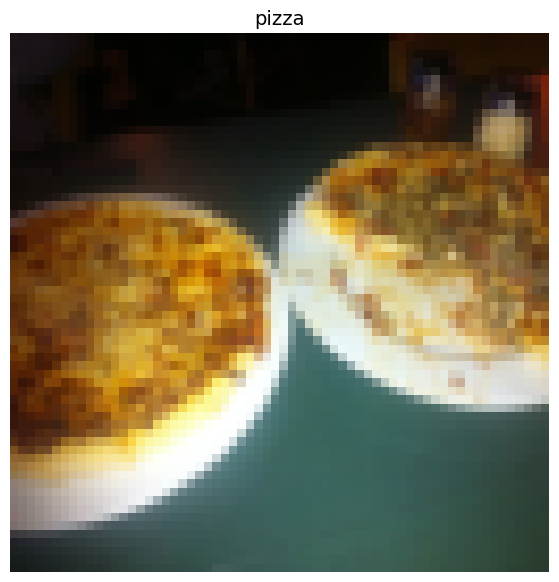

In [41]:
# have to permute (rearrange the order of its dimensions) so it's compatible. (permute를 사용해서 텐서의 차원 순서를 바꿔야함)
# Right now image dimensions are in the format CHW (color channels, height, width) but matplotlib prefers HWC (height, width, color channels).
img_permute = img.permute(1,2,0)

print(f"Original shape: {img.shape} -> [color_channels, height, width]")
print(f"Image permute shape: {img_permute.shape} -> [height, width, color_channels]")

plt.figure(figsize = (10,7))
plt.imshow(img.permute(1,2,0))
plt.axis("off")
plt.title(class_names[label], fontsize=14)

In [47]:
# Turn loaded images into DataLoader's (torch.utils.data.DataLoader)

# Turning Dataset's into DataLoader's makes them iterable so a model can go through and learn the relationships between samples and targets (features and labels)
# num_workers : It defines how many subprocesses will be created to load your data (데이터를 불러오기 위해 몇 개의 하위 프로세스를 생성할지 결정하는 값)
# num_workers의 값이 클수록, PyTorch는 데이터를 불러오기 위해 더 많은 컴퓨팅 자원(compute power)을 사용하게 됨
# os.cpu_count() : 내 컴퓨터의 전체 cpu 개수 (이와 같이 설정하면 DataLoader가 데이터를 불러올 때 최대한 많은 CPU 코어를 활용하게 됨)

from torch.utils.data import DataLoader
train_dataloader = DataLoader(dataset = train_data,
                              batch_size=1,
                              num_workers=1,
                              shuffle=True)
test_dataloader = DataLoader(dataset=test_data,
                             batch_size=1,
                             num_workers=1,
                             shuffle=False)

print(train_dataloader)
print(test_dataloader)

In [48]:
img, label = next(iter(train_dataloader))

print(f"Image shape: {img.shape} -> [batch_size, color_channels, height, width]")
print(f"Label shape: {label.shape}")

Image shape: torch.Size([1, 3, 64, 64]) -> [batch_size, color_channels, height, width]
Label shape: torch.Size([1])


# Option 2: Loading Image Data with a Custom Dataset  (if a pre-built Dataset creator like torchvision.datasets.ImageFolder() didn't exist)

pros and cons of creating your own custom way to load Dataset's
  1. Can create a Dataset out of almost anything  /  Even though you could create a Dataset out of almost anything, it doesn't mean it will work
  2. Not limited to PyTorch pre-built Dataset functions / Using a custom Dataset often results in writing more code, which could be prone to errors or performance issues


In [49]:
# replicating torchvision.datasets.ImageFolder() by subclassing torch.utils.data.Dataset (the base class for all Dataset's in PyTorch).

# Python's os for dealing with directories (our data is stored in directories)
# Python's pathlib for dealing with filepaths (each of our images has a unique filepath)
# torch for all things PyTorch
# PIL's Image class for loading images
# torch.utils.data.Dataset to subclass and create our own custom Dataset
# torchvision.transforms to turn our images into tensors
# Various types from Python's typing module to add type hints to our code

import os
import pathlib
import torch

from PIL import Image
from torch.utils.data import Dataset
from torchvision import transforms
from typing import Tuple, Dict, List

In [ ]:
# Creating a helper function to get class names

# write a helper function capable of creating a list of class names and a dictionary of class names and their indexes given a directory path.
# 1. Get the class names using os.scandir() to traverse(탐색하다) a target directory (ideally the directory is in standard image classification format).
  # (os.scandir()를 사용해 대상 디렉토리를 탐색하며 클래스 이름을 얻음(이 디렉토리는 이상적으로 표준 이미지 분류 포맷이어야함))
# 2. Raise an error if the class names aren't found (if this happens, there might be something wrong with the directory structure).
# 3. Turn the class names into a dictionary of numerical labels, one for each class.
  # (클래스 이름들을 각 클래스에 대한 숫자 레이블 딕셔너리로 변환)

target_directory = train_dir
print(f"Target directory: {target_directory}")

class_names_found = sorted([entry.name for entry in list(os.scandir(image_path / "train"))]) # entry는 os.DirEntry의 객체, 이 객체에서 파일 또는 폴더명에 해당하는 속성이 .name
print(f"Class names found: {class_names_found}")
# os.scandir로 해당 경로의 디렉토리를 스캔
# 이 디렉토리에 있는 모든 항목에 대해 각 항목의 이름 entry.name을 리스트로 만듦

Target directory: data\pizza_steak_sushi\train
Class names found: ['pizza', 'steak', 'sushi']


In [53]:
print(list(os.scandir(image_path / "train")))

[<DirEntry 'pizza'>, <DirEntry 'steak'>, <DirEntry 'sushi'>]


In [ ]:
def find_classes(directory:str) -> Tuple[List[str], Dict[str, int]]:
    classes = sorted(entry.name for entry in os.scandir(directory) if entry.is_dir())  # 디렉토리 안에 있는 항목들 중에서 폴더인 것만 골라내기 위한 조건 (is_dir())

    if not classes: # 하위 폴더가 없을 때 에러를 발생시킴
        raise FileNotFoundError(f"Couldn't find any classes in {directory}")
    
    class_to_idx = {cls_name: i for i, cls_name in enumerate(classes)}
    return classes, class_to_idx

In [55]:
print(find_classes(train_dir))

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})


# Create a custom Dataset to replicate ImageFolder

1. Subclass torch.utils.data.Dataset

2. Initialize our subclass with a targ_dir parameter (the target data directory) and transform parameter (the option to transform our data if needed)
   (서브클래스의 생성자 함수(__init__)를 정의할 때, targ_dir과 transform 파라미터를 포함)

3. Create several attributes for paths (the paths of our target images), transform (the transforms we might like to use, this can be None), 
classes and class_to_idx (from our find_classes() function)

4. Create a function to load images from file and return them, this could be using PIL or torchvision.io (for input/output of vision data)
   (이미지 파일을 불러와 반환하는 함수를 만듦)

5. Overwrite(덮어쓰다) the __len__ method of torch.utils.data.Dataset to return the number of samples in the Dataset, 
this is recommended but not required. This is so you can call len(Dataset)
   (Dataset 안에 있는 샘플의 개수를 반환하는 __len__()메서드를 덮어씀, __len__메서드를 구현하면 len(Dataset)으로 쉽게 크기를 알 수 있음)

6. Overwrite the __getitem__ method of torch.utils.data.Dataset to return a single sample from the Dataset, this is required

In [ ]:
from torch.utils.data import Dataset

class ImageFolderCustom(Dataset): # torch.utils.data.Dataset을 상속
    def __init__(self, targ_dir: str, transform=None) -> None:
        self.paths = list(pathlib.Path(targ_dir).glob("*/*.jpg"))  # glob() : 패턴에 맞는 파일 경로를 찾아주는 함수  # targ_dir 디렉토리 하위의 각 클래스 폴더 안에 있는 모든 .jpg파일 경로를 리스트로 추출
        self.transform = transform
        self.classes, self.class_to_idx = find_classes(targ_dir)

    # make function to load images
    def load_image(self, index: int) -> Image.Image:
        image_path = self.paths[index] # 경로를 통해 이미지를 열고 반환
        return Image.open(image_path)
    
    def __len__(self) -> int:
        return len(self.paths) #전체 데이터 샘플 수 반환
    
    # overwrite the __getitem__() method (required for subclasses of torch.utils.data.Dataset)
    def __getitem__(self, index:int) -> Tuple[torch.Tensor, int]:
        img = self.load_image(index) # 이미지 로드
        class_name = self.paths[index].parent.name  # expects path in data_folder/class_name/image.jpeg
        class_idx = self.class_to_idx[class_name]

        # Transform if necessary
        if self.transform:
            return self.transform(img), class_idx  # 변환된 이미지와 클래스 인덱스 반환
        else:
            return img, class_idx  # 원본 이미지와 클래스 인덱스 반환

In [58]:
# Augment train data
train_transforms = transforms.Compose([transforms.Resize((64,64)),
                                       transforms.RandomHorizontalFlip(p=0.5),
                                       transforms.ToTensor()])

# Don't augment test data, only reshape
test_transforms = transforms.Compose([transforms.Resize((64,64)),
                                      transforms.ToTensor()])

In [60]:
train_data_custom = ImageFolderCustom(targ_dir=train_dir,
                                      transform=train_transforms)
test_data_custom = ImageFolderCustom(targ_dir=test_dir,
                                     transform = test_transforms)
print(train_data_custom)
print(test_data_custom)

In [61]:
print(len(train_data_custom), len(test_data_custom))

225 75


In [62]:
print(train_data_custom.classes)

['pizza', 'steak', 'sushi']


In [63]:
print(train_data_custom.class_to_idx)

{'pizza': 0, 'steak': 1, 'sushi': 2}


In [65]:
# check for equality amongst our custom Dataset and ImageFolder Dataset
print((len(train_data_custom) == len(train_data)) & (len(test_data_custom) == len(test_data)))
print(train_data_custom.classes == train_data.classes)
print(train_data_custom.class_to_idx == train_data.class_to_idx)

True
True
True


# Create a function to display random images

create a helper function called display_random_images() that helps us visualize images in Dataset's
1. Take in a Dataset and a number of other parameters such as classes (the names of our target classes), the number of images to display (n) and a random seed
   (Dataset과 함께, 클래스 이름들, 출력할 이미지 수(n), 랜덤 시드 등의 매개변수를 입력받음)

2. To prevent the display getting out of hand(통제되지 않는), we'll cap(최대치를 제한하다) n at 10 images
   (화면에 너무 많은 이미지가 뜨는 것을 방지하기 위해, n의 최대값을 10으로 제한)

3. Set the random seed for reproducible plots (if seed is set)

4. Get a list of random sample indexes (can use Pytho's random.sample() for this) to plot

5. Setup a matplotlib plot

6. Loop thorugh the random sample indexes found in step 4 and plot them with matplotlib

7. Make sure the smaple images are of shape HWC (height, width, color channels) so we can plot them

In [ ]:
def display_random_images(dataset: torch.utils.data.dataset.Dataset,
                          classes: List[str] = None,
                          n: int = 10,
                          display_shape: bool = True,
                          seed: int = None):
    
    # adjust display if n too high
    if n>10:
        n=10
        display_shape = False
        print(f"For display purposes, n shouldn't be larger than 10, setting to 10 and removing shape display")
    
    if seed:
        random.seed(seed)
    
    # get random sample indexes
    random_samples_idx = random.sample(range(len(dataset)), k=n)

    plt.figure(figsize= (16,8))


    for i, targ_sample in enumerate(random_samples_idx):
        targ_image, targ_label = dataset[targ_sample][0], dataset[targ_sample][1]

        # adjust image tensor shape for plotting(matplotlib): [color_channels, height, width] -> [height, width, color_channels]
        targ_image_adjust = targ_image.permute(1,2,0)

        plt.subplot(1,n,i+1)
        plt.imshow(targ_image_adjust)
        plt.axis("off")
        
        if classes:
            title = f"class: {classes[targ_label]}"
            if display_shape:
                title = title + f"\nshape: {targ_image_adjust.shape}"
        plt.title(title)

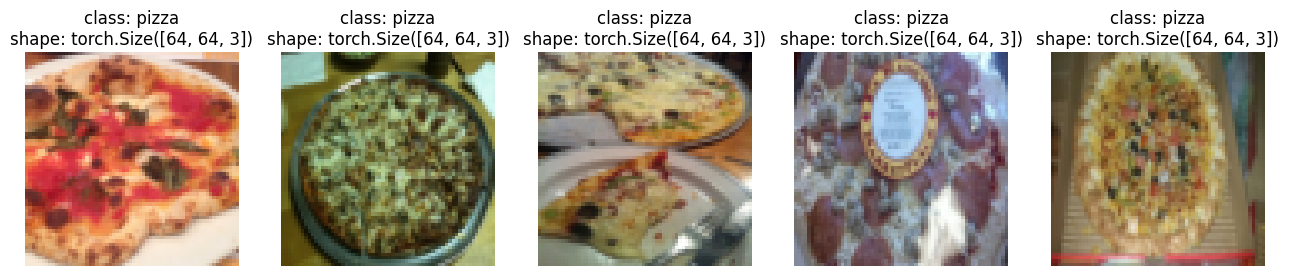

In [ ]:
# display random images from ImageFolder created Dataset
display_random_images(train_data,
                      n=5,
                      classes = class_names,
                      seed = None)

For display purposes, n shouldn't be larger than 10, setting to 10 and removing shape display


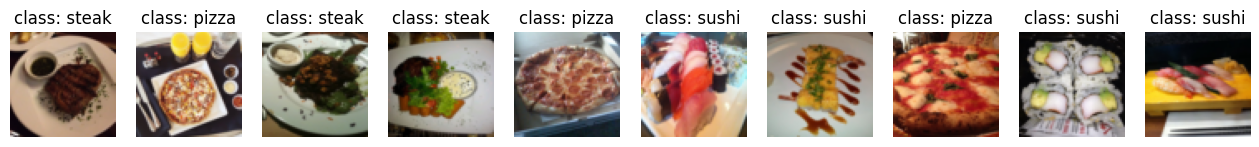

In [78]:
# display random images from ImageFolderCustom Dataset
display_random_images(train_data_custom,
                      n=12,
                      classes=class_names,
                      seed=None)

In [79]:
# Turn custom loaded images into DataLoader's

# Turn train and test custom Dataset's into DataLoader's
from torch.utils.data import DataLoader
train_dataloader_custom = DataLoader(dataset=train_data_custom,
                                     batch_size=1,
                                     num_workers=0,
                                     shuffle=True)

test_dataloader_custom = DataLoader(dataset=test_data_custom,
                                    batch_size=1,
                                    num_workers=0,
                                    shuffle=False)

print(train_dataloader_custom)
print(test_dataloader_custom)

In [80]:
# get image and label from custom DataLoader
img_custom, label_custom = next(iter(train_dataloader_custom))

print(f"Image shape: {img_custom.shape} -> [batch_size, color_channels, height, width]")
print(f"Label shape: {label_custom.shape}")

Image shape: torch.Size([1, 3, 64, 64]) -> [batch_size, color_channels, height, width]
Label shape: torch.Size([1])


# Other forms of transforms (data augmentation)

The purpose of transforms is to alter your images in some way
That may be turning your images into a tensor
Or cropping it or randomly erasing a portion or randomly rotating them
Doing these kinds of transforms is often referred to as data augmentation(데이터 증강)

Data augmentation is the process of altering your data in such a way that you artificially increase the diversity of your training set
(데이터 증강이란, 데이터를 변화시켜 훈련 데이터셋의 다양성을 인위적으로 증가시키는 과정)
Training a model on this artificially altered dataset hopefully results in a model that is capable of better generalization (the patterns it leaarns are more robust to future unseen examples)

Machine learning is all about harnessing(활용하는 것) the power of randomness and research shows that random transforms (like transforms.RandAugment() and transforms.TrivialAugmentWide()) generally perform better than hand-picked transforms.


# TrivialAugment
The idea behind TrivialAugment is trivial(단순한)
You have a set of transforms and you randomly pick a number of them to perform on an image and at a random magnitude between a given range (a higher magnitude means more intense)
(여러 가지 변형들을 모아놓고, 그 중 몇 개를 무작위로 선택해서 이미지에 적용함. 또한 변형의 강도(magnitude) 역시 주어진 범위 내에서 무작위로 정해짐(값이 클수록 더 강한 변형이 적용됨))

The main parameter to pay attention to in transforms.TrivialAugmentWide() is num_magnitude_bins=31
- num_magnitude_bins=31 : It defines how much of a range an intensity value will be picked to apply a certain transform, 0 being no range and 31 being maximum range (highest chance for highest intensity)
(이 값은 변형을 적용할 때 강도(intensity) 값이 어느 범위에서 선택되는지를 정의, 0이면 변화가 거의 없고, 31이면 가장 큰 범위 내에서 선택되므로 강도가 높을 확률이 커짐)

+ can incoporate transforms.TrivialAugmentWide() into transforms.Compose()

In [ ]:
from torchvision import transforms

train_transforms = transforms.Compose([transforms.Resize((224,224)),
                                       transforms.TrivialAugmentWide(num_magnitude_bins=31),
                                       transforms.ToTensor()])

# Don't need to perform augmentation on the test data
test_transforms = transforms.Compose([transforms.Resize((224,224)),
                                      transforms.ToTensor()]) # 원래 이미지의 픽셀 값은 0~255 사이의 정수 -> 0.0~1.0 사이의 실수로 나눠줌

# Usually don't perform data augmentation on the test set
# The idea of data augmentation is to artificially increase the diversity of the training set to better predict on the testing set
# (데이터 증강의 목적은 훈련 데이터셋의 다양성을 인위적으로 늘려서, 테스트 세트에 대한 예측 성능을 높이기 위한 것)


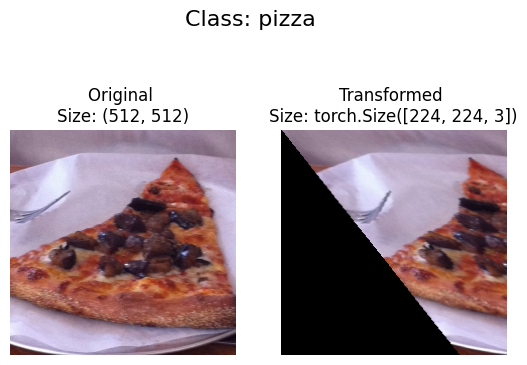

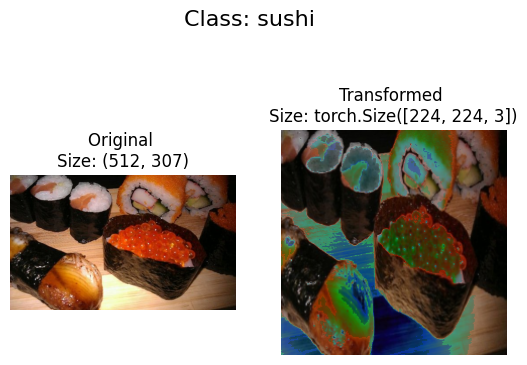

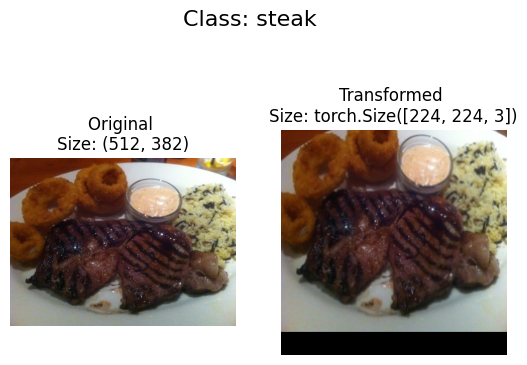

In [86]:
# get all image path
image_path_list = list(image_path.glob("*/*/*.jpg"))

# plot random images
plot_transformed_images(image_paths = image_path_list,
                        transform=train_transforms,
                        n=3,
                        seed=None)

In [87]:
# Model 0:TinyVGG without data augmentation

# how to turn data from images in folders to transformed tensors

# creating transforms and loading data for Model 0
simple_transform = transforms.Compose([
    transforms.Resize((64,64)),
    transforms.ToTensor(),
])

In [89]:
# 1. Load the data, turning each of our training and test folders first into a Dataset with torchvision.datasets.ImageFolder()
# 2. Then into a DataLoader using torch.utils.data.DataLoader()

# load and transform data
from torchvision import datasets
train_data_simple = datasets.ImageFolder(root=train_dir, transform=simple_transform)
test_data_simple = datasets.ImageFolder(root=test_dir, transform=simple_transform)

# turn data into DataLoaders
import os
from torch.utils.data import DataLoader

BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()
print(f"Creating DataLoader's with batch size {BATCH_SIZE} and {NUM_WORKERS} workers")

# create DataLoader's
train_dataloader_simple = DataLoader(train_data_simple,
                                     batch_size=BATCH_SIZE,
                                     shuffle=True,
                                     num_workers=NUM_WORKERS)
test_dataloader_simple = DataLoader(test_data_simple,
                                    batch_size=BATCH_SIZE,
                                    shuffle= False,
                                    num_workers=NUM_WORKERS)
print(train_dataloader_simple)
print(test_dataloader_simple)

Creating DataLoader's with batch size 32 and 40 workers


In [91]:
# create TinyVGG model class
class TinyVGG(nn.Module):
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int) -> None:
        super().__init__()
        self.conv_block_1 =nn.Sequential(
            nn.Conv2d(in_channels=input_shape,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1, # default
                      padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,
                         stride=2) # default stride value is same as kernel_size
        )
        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(hidden_units, hidden_units, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(hidden_units, hidden_units, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=hidden_units*16*16, # where did this in_features shape come from? -> It's beacuase each layer of our network compresses and changes the shape of our input data
                      out_features=output_shape)
        )
    def forward(self, x: torch.Tensor):
        x = self.conv_block_1(x)
        x = self.conv_block_2(x)
        x = self.classifier(x)
        return x

torch.manual_seed(42)
model_0 = TinyVGG(input_shape=3,
                  hidden_units=10,
                  output_shape=len(train_data.classes)).to(device)
print(model_0)

# one of the ways to speed up deep learning models computing on a GPU is to leverage operator fusion
# This means in the forward() method in our model above, instead of calling a layer block and reassigning x every time, we call each block in succession
# def forward(self, x):
#    return self.classifier(self.conv_block_2(self.conv_block_1(x))) <- 해당 방법이 더 효율적

TinyVGG(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=2560, out_features=3, bias=True)
  )
)


In [94]:
# Try a forward pass on a single image (to test the model)

# A good way to test a model is to do a forward pass on a single piece of data
# It's also handy way to test the input and output shapes of our different layers

# 1. Get a batch of images and labels from the DataLoader
# 2. Get a single image from the batch and unsqueeze() the image so it has a batch size of 1 (so its shape fits the model)
# 3. Perform inference on a single image (making sure  to send the image to the target device)  (단일 이미지에 대해 추론을 수행)
# 4. Print out what's happening and convert the model's raw output logits to prediction probabilities with torch.softmax() (since we're working with multi-class data) and convert the prediction probabilities to prediction labels with torch.argmax()

img_batch, label_batch = next(iter(train_dataloader_simple))

img_single, label_single = img_batch[0].unsqueeze(dim=0), label_batch[0]
print(f"Single image shape: {img_single.shape}\n")

model_0.eval()
with torch.inference_mode():
    pred = model_0(img_single.to(device))

print(f"Output logits:\n{pred}\n")
print(f"Output prediction probabilities:\n{torch.softmax(pred, dim=1)}\n")
print(f"Output prediction label:\n{torch.argmax(torch.softmax(pred,dim=1), dim=1)}")
print(f"Actual label:\n{label_single}")

Single image shape: torch.Size([1, 3, 64, 64])

Output logits:
tensor([[0.0637, 0.0615, 0.0382]], device='cuda:0')

Output prediction probabilities:
tensor([[0.3364, 0.3357, 0.3279]], device='cuda:0')

Output prediction label:
tensor([0], device='cuda:0')
Actual label:
1


In [ ]:
# Use torchinfo to get an idea of the shapes ogoing through our model

# torchinfo comes with a summary() method that takes a PyTorch model as well as an input_shape and returns what happens as a tensor moves through your model
try:
    import torchinfo
except:
    !pip install torchinfo
    import torchinfo

from torchinfo import summary
summary(model_0, input_size = [1,3,64,64])  # do a test pass through of an example input size

# The output of torchinfo.suammry() gives us a whole bunch of information about our model
# Such as Total params, the total number of parameters in our model, the Estimated Total Size(MB) which is the size of our model
# can also see the change in input and output shapes as data of a certain input_size moves through the model

Layer (type:depth-idx)                   Output Shape              Param #
TinyVGG                                  [1, 3]                    --
├─Sequential: 1-1                        [1, 10, 32, 32]           --
│    └─Conv2d: 2-1                       [1, 10, 64, 64]           280
│    └─ReLU: 2-2                         [1, 10, 64, 64]           --
│    └─Conv2d: 2-3                       [1, 10, 64, 64]           910
│    └─ReLU: 2-4                         [1, 10, 64, 64]           --
│    └─MaxPool2d: 2-5                    [1, 10, 32, 32]           --
├─Sequential: 1-2                        [1, 10, 16, 16]           --
│    └─Conv2d: 2-6                       [1, 10, 32, 32]           910
│    └─ReLU: 2-7                         [1, 10, 32, 32]           --
│    └─Conv2d: 2-8                       [1, 10, 32, 32]           910
│    └─ReLU: 2-9                         [1, 10, 32, 32]           --
│    └─MaxPool2d: 2-10                   [1, 10, 16, 16]           --
├─Sequentia

In [99]:
# Create train & test loop functions

# 1. train_step() - takes in a model, a DataLoader, a loss function and an optimizer and trains the model on the DataLoader
# 2. test_step() - takes in a model, a DataLoader and a loss function and evaluates the model on the DataLoader
# 3. train() - performs 1. and 2. together for a given number of epochs and returns a results dictionary

import torch.utils.data.dataloader


def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer):
    model.train()

    train_loss, train_acc = 0, 0
    
    for batch, (X,y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        y_pred = model(X)

        loss = loss_fn(y_pred, y)
        train_loss += loss.item()

        optimizer.zero_grad()

        loss.backward()

        optimizer.step()

        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        train_acc += (y_pred_class ==y).sum().item()/len(y_pred)

    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)
    return train_loss, train_acc


def test_step(model: torch.nn.Module,
              dataloader: torch.utils.data.dataloader,
              loss_fn: torch.nn.Module):
        model.eval()

        test_loss, test_acc = 0,0

        with torch.inference_mode():
            for batch, (X,y) in enumerate(dataloader):
                X, y = X.to(device), y.to(device)

                test_pred_logits = model(X)

                loss = loss_fn(test_pred_logits,y)
                test_loss += loss.item()

                test_pred_labels = test_pred_logits.argmax(dim=1)
                test_acc += ((test_pred_labels==y).sum().item()/len(test_pred_labels))
        test_loss = test_loss / len(dataloader)
        test_acc = test_acc / len(dataloader)
        return test_loss, test_acc

In [107]:
# Creating a train() function to combine train_step() and test_step()

# 1. Take in a model, a DataLoader for training and test sets, an optimizer, a loss function and how many epochs to perform each train and test step for
# 2. Create an empty results dictionary for train_loss, train_acc, test_loss and test_acc values (we can fill this up as training goes on)
# 3. Loop through the training and test step functions for a number of epochs
# 4. Print out what's happening at the end of each epoch
# 5. Update the empty results dictionary with the updated metrics each epoch
# 6. Return the filled

from tqdm.auto import tqdm

def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module = nn.CrossEntropyLoss(),
          epochs: int=5):
    
    # create empty results dictionary
    results = {"train_loss": [],
               "train_acc": [],
               "test_loss": [],
               "test_acc": []}
    
    for epoch in tqdm(range(epochs)):  # range(epochs)를 tqdm으로 감싸, 반복 진행 상태를 시각적으로 표시해주는 progress bar가 만들어짐
        train_loss, train_acc = train_step(model=model,
                                           dataloader= train_dataloader,
                                           loss_fn = loss_fn,
                                           optimizer=optimizer)
        test_loss, test_acc = test_step(model=model,
                                        dataloader=test_dataloader,
                                        loss_fn=loss_fn)
        
        print(f"Epoch: {epoch+1} | "
              f"train_loss: {train_loss:.4f} | "
              f"train_acc: {train_acc:.4f} | "
              f"test_loss: {test_loss:.4f} | "
              f"test_acc: {test_acc:.4f} | ")
        
        results["train_loss"].append(train_loss.item() if isinstance(train_loss, torch.Tensor) else train_loss)  # isinstance(train_loss, torch.Tensor) - train_loss가 torch.Tensor 타입인지 확인
        results["train_acc"].append(train_acc.item() if isinstance(train_acc, torch.Tensor) else train_acc)
        results["test_loss"].append(test_loss.item() if isinstance(test_loss, torch.Tensor) else test_loss)
        results["test_acc"].append(test_acc.item() if isinstance(test_acc, torch.Tensor) else test_acc)
    
    return results

In [108]:
# Train and Evaluate Model 0

# torch.optim.Adam() - learning rate of 1e-3

torch.manual_seed(42)
torch.cuda.manual_seed(42)

NUM_EPOCHS = 5

model_0 = TinyVGG(input_shape=3, # number of color channels
                  hidden_units=10,
                  output_shape=len(train_data.classes)).to(device)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_0.parameters(), lr=0.001)

from timeit import default_timer as timer
start_time = timer()

model_0_results = train(model=model_0,
                        train_dataloader=train_dataloader_simple,
                        test_dataloader=test_dataloader_simple,
                        optimizer = optimizer,
                        loss_fn = loss_fn,
                        epochs=NUM_EPOCHS)

end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")

 20%|██        | 1/5 [01:03<04:14, 63.74s/it]

Epoch: 1 | train_loss: 1.1078 | train_acc: 0.2578 | test_loss: 1.1362 | test_acc: 0.2604 | 


 40%|████      | 2/5 [02:07<03:11, 63.88s/it]

Epoch: 2 | train_loss: 1.0846 | train_acc: 0.4258 | test_loss: 1.1622 | test_acc: 0.1979 | 


 60%|██████    | 3/5 [03:11<02:07, 63.95s/it]

Epoch: 3 | train_loss: 1.1146 | train_acc: 0.2930 | test_loss: 1.1683 | test_acc: 0.1979 | 


 80%|████████  | 4/5 [04:15<01:03, 63.74s/it]

Epoch: 4 | train_loss: 1.1015 | train_acc: 0.3125 | test_loss: 1.1318 | test_acc: 0.2604 | 


100%|██████████| 5/5 [05:18<00:00, 63.76s/it]

Epoch: 5 | train_loss: 1.0977 | train_acc: 0.2930 | test_loss: 1.1445 | test_acc: 0.1979 | 
Total training time: 318.788 seconds


In [ ]:
# Plot the loss curves of Model 0

# can further evaluate it by plotting the model's loss curves (손실 곡선을 그려보면 모델을 더 깊이 평가할 수 있음)
# Loss curves show the model's results over time

model_0_results.keys()

dict_keys(['train_loss', 'train_acc', 'test_loss', 'test_acc'])

In [111]:
def plot_loss_curves(results: Dict[str, List[float]]):
    loss = results['train_loss']
    test_loss = results['test_loss']

    accuracy = results['train_acc']
    test_accuracy = results['test_acc']

    epochs = range(len(results['train_loss']))

    plt.figure(figsize=(15,7))

    plt.subplot(1,2,1)
    plt.plot(epochs,loss,label='train_loss')
    plt.plot(epochs, test_loss, label='test_loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.legend()

    plt.subplot(1,2,2)
    plt.plot(epochs,accuracy, label='train_accruacy')
    plt.plot(epochs, test_accuracy, label='test_accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.legend()

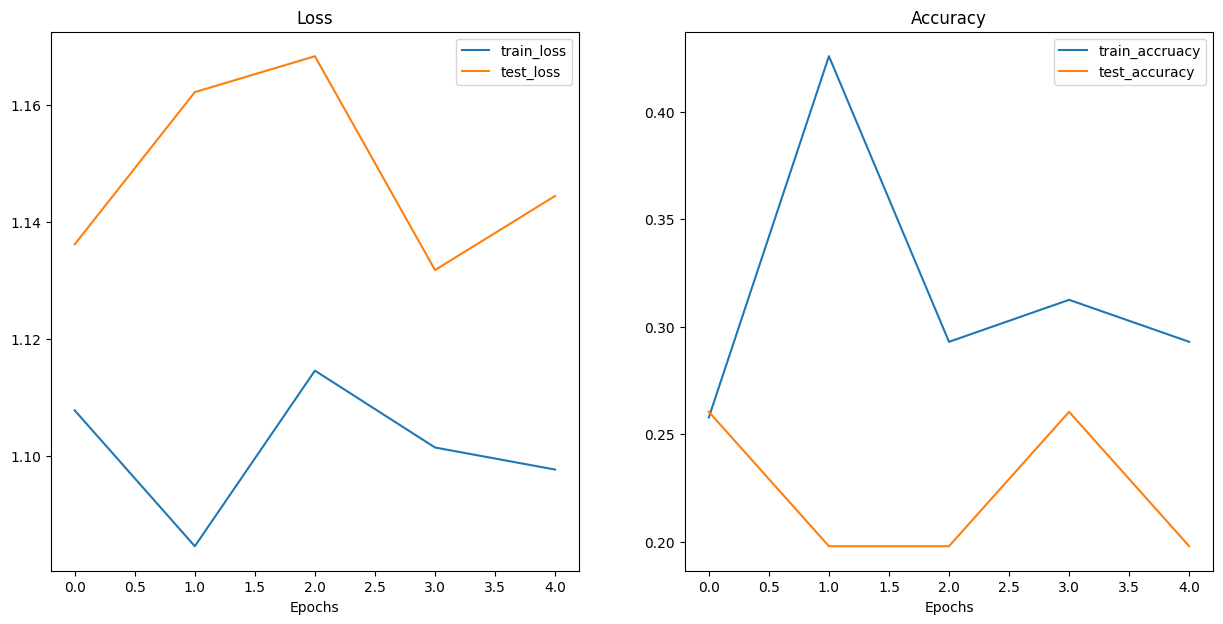

In [112]:
plot_loss_curves(model_0_results)

# What should an ideal loss curve look like?

Looking at training and test loss curves is a great way to see if the model is overfitting
An overfitting model is one that performs better (often by a considerable margin(꽤 큰 차이로)) on the training set than the validation(검증)/test set
If training loss is far lower than test loss, the model is overfitting
If your training loss is far lower than your test loss, your model is overfitting (훈련 데이터의 패턴을 너무 학습하여, 해당 패턴들이 일반화되지 못함)
The other side is when your training and test loss are not as low as you'd like, this is considered underfitting (훈련 손실과 테스트 손실 모두 충분히 낮지 않다면 과소적합(underfitting))
The ideal position for a training and test loss curve is for them to line up closely with each other

# How to deal with overfitting

A common technique of preventing overfitting is known as regularization(정규화)

- few methods to prevent overfitting
1. get more data
 - Having more data gives the model more opportunities to learn patterns, patterns which may be more generalizable to new examples

2. simplify your model
 - If the current model is already overfitting the training data, it may be too complicated of a model. This means it's learning the patterns of the data too well 
  and isn't able to generalize well to unseen data. One way to simplify a model is to reduce the number of layers it uses or to reduce the number of hidden units in each layer
  (레이어 수를 줄이거나 각 레이어의 hidden units 수를 줄이는 것)

3. use data augmentation
 - Data augmentation manipulates the training data in a way so that's harder for the model to learn as it artificially adds more variety to the data. If a model is able to learn patterns in augmented data, the model may be able to generalize better to unseen data

4. use transfer learning(전이학습)
 - Transfer learning involves leveraging the patterns (also called pretrained weights) one model has learned to use as the foundation for your own task. In our case, we could use one computer vision model pretrained on a large variety of images and then tweak it slightly to be more specialized for food images
 (다른 모델이 이미 학습한 패턴(사전 학습된 가중치)을 기반으로 자신의 과제에 활용하는 방법)

5. use dropout layers
 - Dropout layers randomly remove connections between hidden layers in neural networks, effectively simplifying a model but also making the remaining connections better. See torch.nn.Dropout() for more
 (신경망의 은닉층 사이의 연결을 무작위로 제거하여 모델을 간접적으로 단순화, 남은 연결이 더 나아지게 함)

6. use learning rate decay (학습률 감소)
 - The idea here is to slowly decrease the learning rate as a model trains. This is akin to reaching for a coin at the back of a couch. The closer you get, the smaller your steps. The same with the learning rate, the closer you get to convergence(수렴), the smaller you'll want your weight updates to be
 (모델이 훈련될수록 학습률을 점차 줄이는 것)

7. use early stopping
 - 	Early stopping stops model training before it begins to overfit. As in, say the model's loss has stopped decreasing for the past 10 epochs (this number is arbitrary), you may want to stop the model training here and go with the model weights that had the lowest loss (10 epochs prior)
 (모델이 과적합되기 전에 훈련을 중단하는 방법)

# How to deal with underfitting

The main idea behind dealing with underfitting is to increase the model's predictive power

1. Add more layers/units to the model
 - If the model is underfitting, it may not have enough capability to learn the required patterns/weights/representations of the data to be predictive. One way to add more predictive power to your model is to increase the number of hidden layers/units within those layers

2. Tweak(조정하다) the learning rate
 - Perhaps your model's learning rate is too high to begin with. And it's trying to update its weights each epoch too much, in turn not learning anything. In this case, you might lower the learning rate and see what happens

3. Use transfer learning(전이학습)
 - Transfer learning is capable of preventing overfitting and underfitting. It involves using the patterns from a previously working model and adjusting them to your own problem
  (전이 학습은 overfitting과 underfitting을 모두 방지할 수 있음, 기존에 잘 작동하던 모델이 학습한 패턴을 가져와 자신의 문제에 맞게 조정하는 방법) 

4. Train for longer
 - Sometimes a model just needs more time to learn representations of data. If you find in your smaller experiments your model isn't learning anything, perhaps leaving it train for a more epochs may result in better performance

5. Use less regularization (정규화)
 - Perhaps the model is underfitting because you're trying to prevent overfitting too much. Holding back on regularization techniques can help the model fit the data better 
  (overfitting을 지나치게 억제하려다 오히려 모델이 underfitting 될 수 있음, regularization techniques을 덜 사용하는 것이 도움이 될 수 있음)



 + Transfer learning is perhaps one of the most powerful techniques when it comes to dealing with both overfitting and underfitting on your own problems
   (전이학습은 과적합과 과소적합을 동시에 다루는 데 있어 가장 강력한 기법 중 하나임)
   

In [113]:
# Model 1: TinyVGG with Data Augmentation

# create transform with data augmentation
# compose a training transform to include transforms.TrivialAugmentWide() as well as resize and turn our images into tensors

train_transform_trivial_augment = transforms.Compose([transforms.Resize((64,64)),
                                                      transforms.TrivialAugmentWide(num_magnitude_bins=31),
                                                      transforms.ToTensor()])

test_transform = transforms.Compose([transforms.Resize((64,64)),
                                     transforms.ToTensor()])

In [115]:
# create train and test Dataset's and DataLoader's

# Dataset uses the train_transform_trivial_augment and the test Dataset uses the test_transform
train_data_augmented = datasets.ImageFolder(train_dir, transform = train_transform_trivial_augment)
test_data_simple = datasets.ImageFolder(test_dir, transform = test_transform)

print(train_data_augmented)
print(test_data_simple)

Dataset ImageFolder
    Number of datapoints: 225
    Root location: data\pizza_steak_sushi\train
    StandardTransform
Transform: Compose(
               Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
               TrivialAugmentWide(num_magnitude_bins=31, interpolation=InterpolationMode.NEAREST, fill=None)
               ToTensor()
           )
Dataset ImageFolder
    Number of datapoints: 75
    Root location: data\pizza_steak_sushi\test
    StandardTransform
Transform: Compose(
               Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
               ToTensor()
           )


In [116]:
import os 
BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()

torch.manual_seed(42)
train_dataloader_augmented = DataLoader(train_data_augmented,
                                        batch_size=BATCH_SIZE,
                                        shuffle=True,
                                        num_workers=NUM_WORKERS)
test_dataloader_simple = DataLoader(test_data_simple,
                                    batch_size= BATCH_SIZE,
                                    shuffle= False,
                                    num_workers=NUM_WORKERS)
print(train_dataloader_augmented)
print(test_dataloader)

In [117]:
# construct and train Model 1
torch.manual_seed(42)
model_1 = TinyVGG(input_shape=3,
                  hidden_units=10,
                  output_shape=len(train_data_augmented.classes)).to(device)
print(model_1)

TinyVGG(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=2560, out_features=3, bias=True)
  )
)


In [118]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

NUM_EPOCHS = 5

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_1.parameters(), lr=0.001)

from timeit import default_timer as timer
start_time = timer()

model_1_results = train(model = model_1,
                        train_dataloader=train_dataloader_augmented,
                        test_dataloader=test_dataloader_simple,
                        optimizer=optimizer,
                        loss_fn = loss_fn,
                        epochs =NUM_EPOCHS)

end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")

 20%|██        | 1/5 [01:02<04:11, 62.97s/it]

Epoch: 1 | train_loss: 1.1074 | train_acc: 0.2500 | test_loss: 1.1059 | test_acc: 0.2604 | 


 40%|████      | 2/5 [02:06<03:09, 63.05s/it]

Epoch: 2 | train_loss: 1.0790 | train_acc: 0.4258 | test_loss: 1.1385 | test_acc: 0.2604 | 


 60%|██████    | 3/5 [03:09<02:06, 63.18s/it]

Epoch: 3 | train_loss: 1.0802 | train_acc: 0.4258 | test_loss: 1.1696 | test_acc: 0.2604 | 


 80%|████████  | 4/5 [04:12<01:03, 63.34s/it]

Epoch: 4 | train_loss: 1.1286 | train_acc: 0.3047 | test_loss: 1.1620 | test_acc: 0.2604 | 


100%|██████████| 5/5 [05:16<00:00, 63.28s/it]

Epoch: 5 | train_loss: 1.0885 | train_acc: 0.4258 | test_loss: 1.1476 | test_acc: 0.2604 | 
Total training time: 316.395 seconds


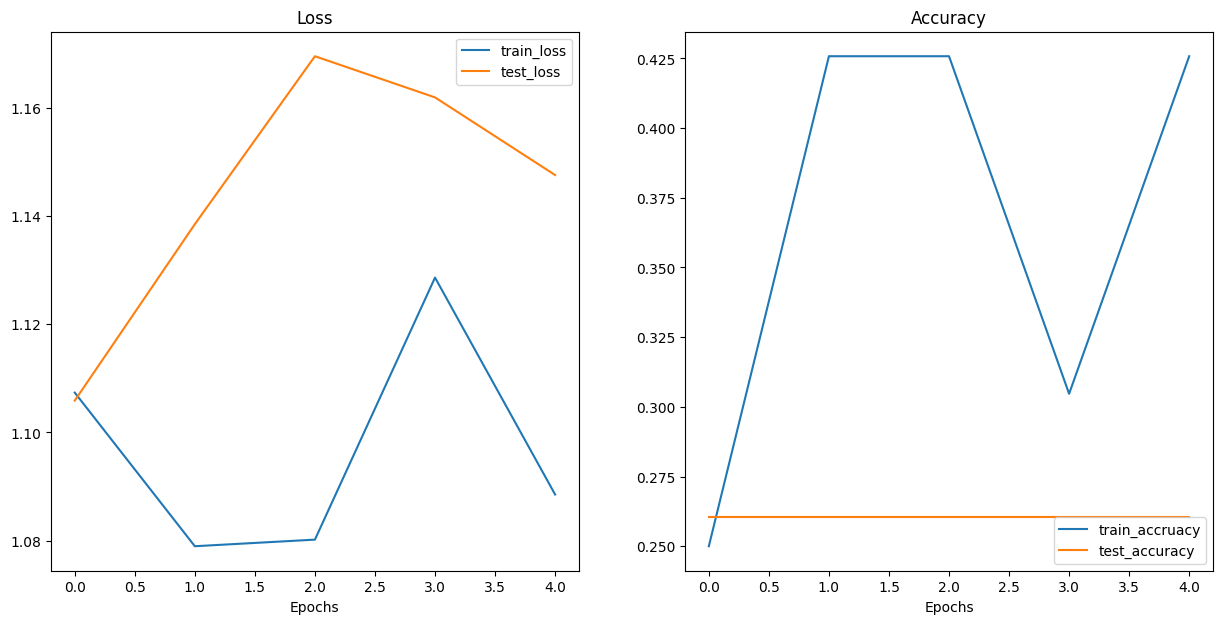

In [119]:
# Plot the loss curves of Model 1
plot_loss_curves(model_1_results)

In [120]:
# compare model results
import pandas as pd
model_0_df = pd.DataFrame(model_0_results)
model_1_df = pd.DataFrame(model_1_results)
print(model_0_df)

   train_loss  train_acc  test_loss  test_acc
0    1.107836   0.257812   1.136203  0.260417
1    1.084644   0.425781   1.162194  0.197917
2    1.114633   0.292969   1.168328  0.197917
3    1.101501   0.312500   1.131809  0.260417
4    1.097737   0.292969   1.144467  0.197917


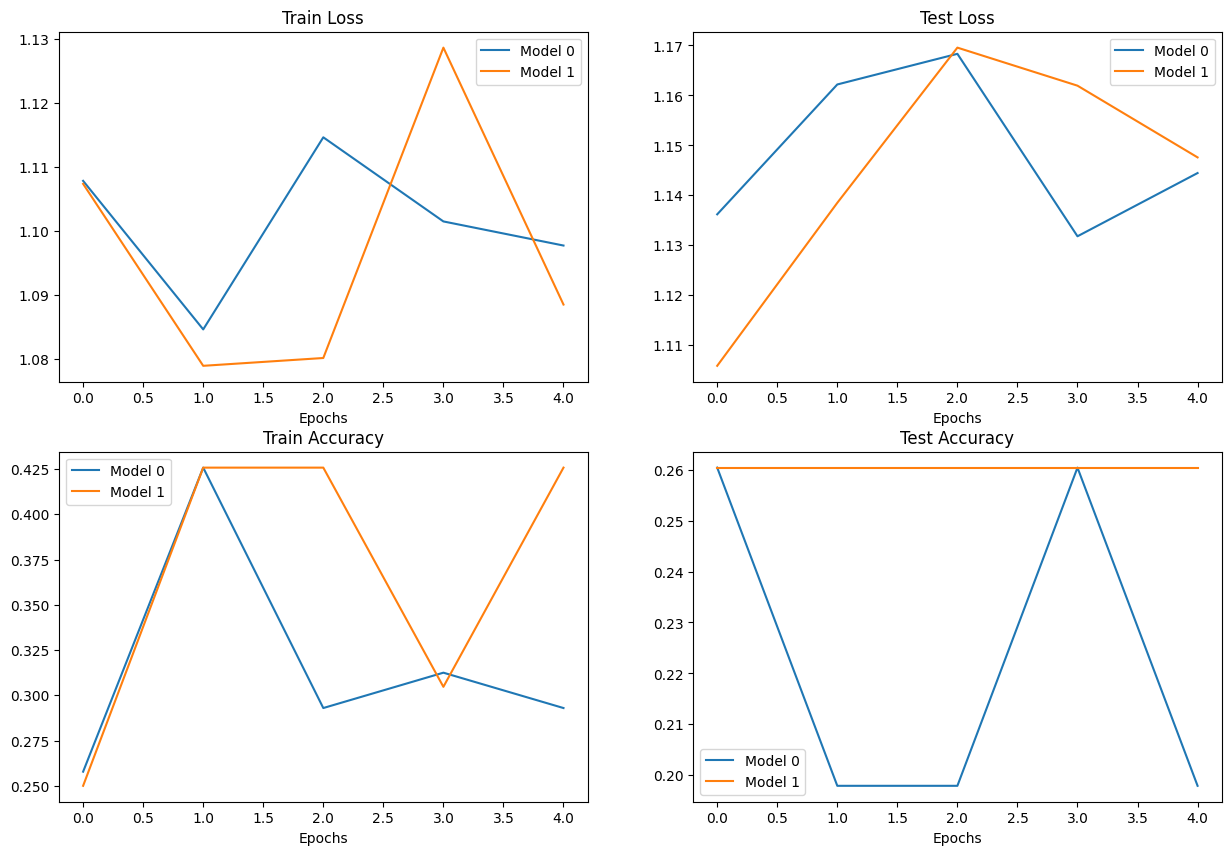

In [121]:
plt.figure(figsize=(15,10))

epochs = range(len(model_0_df))

plt.subplot(2,2,1)
plt.plot(epochs, model_0_df["train_loss"], label="Model 0")
plt.plot(epochs, model_1_df["train_loss"], label="Model 1")
plt.title("Train Loss")
plt.xlabel("Epochs")
plt.legend()

plt.subplot(2,2,2)
plt.plot(epochs, model_0_df["test_loss"], label="Model 0")
plt.plot(epochs, model_1_df["test_loss"], label="Model 1")
plt.title("Test Loss")
plt.xlabel("Epochs")
plt.legend()

plt.subplot(2,2,3)
plt.plot(epochs, model_0_df["train_acc"], label="Model 0")
plt.plot(epochs, model_1_df["train_acc"], label="Model 1")
plt.title("Train Accuracy")
plt.xlabel("Epochs")
plt.legend()

plt.subplot(2,2,4)
plt.plot(epochs, model_0_df["test_acc"], label="Model 0")
plt.plot(epochs, model_1_df["test_acc"], label="Model 1")
plt.title("Test Accuracy")
plt.xlabel("Epochs")
plt.legend()

In [122]:
# Make a prediction on a custom image

# Have to convert our own custom image to a tensor and make sure it's in the right datatype before passing it to our model
import requests

custom_image_path = data_path / "04-pizza-dad.jpeg"

if not custom_image_path.is_file(): # .is_file() - 파일이 있으면 True, 없으면 False (없으면 다운받아야하므로 not을 붙임)
    with open(custom_image_path, "wb") as f:
        request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/04-pizza-dad.jpeg")
        print(f"Downloading {custom_image_path}...")
        f.write(request.content)
else:
    print(f"{custom_image_path} already exists, skipping download")

In [123]:
# Loading in a custom image with PyTorch

# PyTorch's torchvision has several input and output ("IO" or "io" for short) methods for reading and writing images and video in torchvision.io
 # (torchvision.io에 이미지와 비디오를 읽고 쓰기 위한 여러 입출력 메서드들이 있음)

# 이미지 - torchvision.io.read_image()
# this method will read a JPEG or PNG image and turn it into a 3 dimensional RGB or grayscale torch.Tensor with values of datatype uint8 in range [0, 255]
 # (이 메서드는 JPEG 또는 PNG 이미지를 읽어 3차원 RGB 또는 grayscale torch.Tensor로 변환해줌)

import torchvision

custom_image_uint8 = torchvision.io.read_image(str(custom_image_path))

print(f"Custom image tensor:\n{custom_image_uint8}\n")
print(f"Custom image shape: {custom_image_uint8.shape}\n")
print(f"Custom image dtype: {custom_image_uint8.dtype}")

Custom image tensor:
tensor([[[154, 173, 181,  ...,  21,  18,  14],
         [146, 165, 181,  ...,  21,  18,  15],
         [124, 146, 172,  ...,  18,  17,  15],
         ...,
         [ 72,  59,  45,  ..., 152, 150, 148],
         [ 64,  55,  41,  ..., 150, 147, 144],
         [ 64,  60,  46,  ..., 149, 146, 143]],

        [[171, 190, 193,  ...,  22,  19,  15],
         [163, 182, 193,  ...,  22,  19,  16],
         [141, 163, 184,  ...,  19,  18,  16],
         ...,
         [ 55,  42,  28,  ..., 107, 104, 103],
         [ 47,  38,  24,  ..., 108, 104, 102],
         [ 47,  43,  29,  ..., 107, 104, 101]],

        [[119, 138, 147,  ...,  17,  14,  10],
         [111, 130, 145,  ...,  17,  14,  11],
         [ 87, 111, 136,  ...,  14,  13,  11],
         ...,
         [ 35,  22,   8,  ...,  52,  52,  48],
         [ 27,  18,   4,  ...,  50,  49,  44],
         [ 27,  23,   9,  ...,  49,  46,  43]]], dtype=torch.uint8)

Custom image shape: torch.Size([3, 4032, 3024])

Custom image dty

In [124]:
# custom_image tensor is of datatype torch.uint8 and its values are between [0, 255]
# But our model takes image tensors of datatype torch.float32 and with values between [0, 1]
# So before we use our custom image with our model, we'll need to convert it to the same format as the data our model is trained on
 # (커스텀 이미지를 모델에 사용하기 전에, 모델이 학습된 데이터와 같은 형식으로 변환해야함)
model_1.eval()
with torch.inference_mode():
    model_1(custom_image_uint8.to(device))

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x000002317EC5C430>
Traceback (most recent call last):
  File "c:\Users\hyun\.conda\envs\torch\lib\site-packages\torch\utils\data\dataloader.py", line 1663, in __del__
    self._shutdown_workers()
  File "c:\Users\hyun\.conda\envs\torch\lib\site-packages\torch\utils\data\dataloader.py", line 1621, in _shutdown_workers
    if self._persistent_workers or self._workers_status[worker_id]:
AttributeError: '_MultiProcessingDataLoaderIter' object has no attribute '_workers_status'


RuntimeError: Input type (unsigned char) and bias type (float) should be the same

In [125]:
# load in custom image and convert the tensor values to float32
custom_image = torchvision.io.read_image(str(custom_image_path)).type(torch.float32)

# Divide the image pixel values by 255 to get them between [0,1]
custom_image = custom_image / 255

print(f"Custom image tensor:\n{custom_image}\n")
print(f"Custom image shape: {custom_image.shape}\n")
print(f"Custom image dtype: {custom_image.dtype}")

Custom image tensor:
tensor([[[0.6039, 0.6784, 0.7098,  ..., 0.0824, 0.0706, 0.0549],
         [0.5725, 0.6471, 0.7098,  ..., 0.0824, 0.0706, 0.0588],
         [0.4863, 0.5725, 0.6745,  ..., 0.0706, 0.0667, 0.0588],
         ...,
         [0.2824, 0.2314, 0.1765,  ..., 0.5961, 0.5882, 0.5804],
         [0.2510, 0.2157, 0.1608,  ..., 0.5882, 0.5765, 0.5647],
         [0.2510, 0.2353, 0.1804,  ..., 0.5843, 0.5725, 0.5608]],

        [[0.6706, 0.7451, 0.7569,  ..., 0.0863, 0.0745, 0.0588],
         [0.6392, 0.7137, 0.7569,  ..., 0.0863, 0.0745, 0.0627],
         [0.5529, 0.6392, 0.7216,  ..., 0.0745, 0.0706, 0.0627],
         ...,
         [0.2157, 0.1647, 0.1098,  ..., 0.4196, 0.4078, 0.4039],
         [0.1843, 0.1490, 0.0941,  ..., 0.4235, 0.4078, 0.4000],
         [0.1843, 0.1686, 0.1137,  ..., 0.4196, 0.4078, 0.3961]],

        [[0.4667, 0.5412, 0.5765,  ..., 0.0667, 0.0549, 0.0392],
         [0.4353, 0.5098, 0.5686,  ..., 0.0667, 0.0549, 0.0431],
         [0.3412, 0.4353, 0.5333,  ..

(np.float64(-0.5), np.float64(3023.5), np.float64(4031.5), np.float64(-0.5))

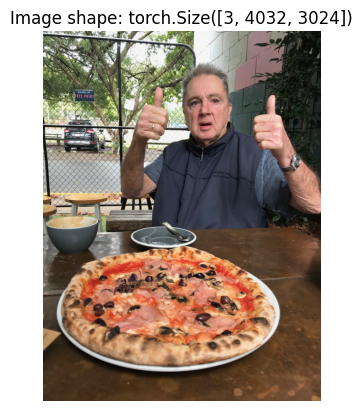

In [126]:
# Predicting on custom images with a trained PyTorch model

# the model was trained on images with shape [3, 64, 64], whereas our custom image is currently [3, 4032, 3024]

# plot custom image
plt.imshow(custom_image.permute(1,2,0))
plt.title(f"Image shape: {custom_image.shape}")
plt.axis(False)

In [127]:
# how could get our image to be the same size as the images the model was trained on 
#-> one way to do so is with torchvision.transforms.Resize()

# create transform pipeline to resize image
custom_image_transform = transforms.Compose([transforms.Resize((64,64))])

custom_image_transformed = custom_image_transform(custom_image)

print(f"Original shape: {custom_image.shape}")
print(f"New shape: {custom_image_transformed.shape}")

Original shape: torch.Size([3, 4032, 3024])
New shape: torch.Size([3, 64, 64])


In [ ]:
model_1.eval()
with torch.inference_mode():
    custom_image_pred = model_1(custom_image_transformed) # 커스텀 이미지와 모델이 서로 다른 디바이스에 존재하여 오류 발생

RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cpu and cuda:0! (when checking argument for argument weight in method wrapper_CUDA___slow_conv2d_forward)

In [130]:
model_1.eval()
with torch.inference_mode():
    custom_image_pred = model_1(custom_image_transformed.to(device))  
# shape error - the model expects image tensors with a batch size dimension at the start (NCHW where N is the batch size)
# Our custom image is currently only CHW

RuntimeError: mat1 and mat2 shapes cannot be multiplied (10x256 and 2560x3)

In [131]:
model_1.eval()
with torch.inference_mode():
    # add an extra dimension to image
    custom_image_transformed_with_batch_size = custom_image_transformed.unsqueeze(dim=0)

    print(f"Custom image transformed shape: {custom_image_transformed.shape}")
    print(f"Unsqueezed custom image shape: {custom_image_transformed_with_batch_size.shape}")

    custom_image_pred = model_1(custom_image_transformed.unsqueeze(dim=0).to(device))

Custom image transformed shape: torch.Size([3, 64, 64])
Unsqueezed custom image shape: torch.Size([1, 3, 64, 64])


# three of the classical and most common deep learning and PyTorch issues

1. Wrong datatypes
 - model expects torch.float32 where our original custom image was uint8

2. Wrong device
 - model was on the target device (in our case, the GPU) whereas target data hadn't been moved to the target device yet

3. Wrong shapes
 - model expected an input image of shape [N, C, H, W] or [batch_size, color_channels, height, width] whereas custom image tensor was of shape [color_channels, height, width]


 + They will be present with almost every kind of data type (text, audio, structured data) and problem work with

In [ ]:
print(custom_image_pred) # still logit form

tensor([[ 0.1182,  0.0273, -0.1453]], device='cuda:0')


In [134]:
# logits -> prediction probabilities -> prediction labels
print(f"Prediction logits: {custom_image_pred}")

custom_image_pred_probs = torch.softmax(custom_image_pred, dim=1)
print(f"Prediction probabilities: {custom_image_pred_probs}")

custom_image_pred_label = torch.argmax(custom_image_pred_probs, dim=1)
print(f"Prediction label: {custom_image_pred_label}")

Prediction logits: tensor([[ 0.1182,  0.0273, -0.1453]], device='cuda:0')
Prediction probabilities: tensor([[0.3729, 0.3405, 0.2865]], device='cuda:0')
Prediction label: tensor([0], device='cuda:0')


In [ ]:
# convert it to a string class name prediction by indexing on the class_names list
custom_image_pred_class = class_names[custom_image_pred_label.cpu()]  
print(custom_image_pred_class)

# custom_image_pred_label.cpu() 를 하지 않으면 에러가 나는 이유는 텐서가 GPU(CUDA 디바이스)에 있을 때, 파이썬의 일반 연산이나 인덱싱 연산을 바로 사용할 수 없기 때문

# cpu로 보내지 않았을 때 : TypeError: list indices must be integers or slices, not torch.cuda.IntTensor

pizza


In [ ]:
print(custom_image_pred_probs) # The values of the prediction probabilities are quite similar

# Having prediction probabilities this similar could mean a couple of things
# 1. The model is trying to predict all three classes at the same time (there may be an image containing pizza, steak and sushi)
  # (세 가지 클래스를 동시에 예측하려고 하는 경우)
# 2. The model doesn't really know what it wants to predict and is in turn just assigning similar values to each of the classes
  # (모델이 무엇을 예측해야 할지 잘 몰라서, 모든 클래스에 비슷한 값을 할당하고 있는 경우)

tensor([[0.3729, 0.3405, 0.2865]], device='cuda:0')


In [138]:
# Putting custom image prediction together: building a function

# 1. Takes in a target image path and converts to the right datatype for the model (torch.float32)
# 2. Makes sure the target image pixel values are in the range [0, 1]
# 3. Transforms the target image if necessary
# 4. Makes sure the model is on the target device
# 5. Makes a prediction on the target image with a trained model (ensuring the image is the right size and on the same device as the model)
# 6. Converts the model's output logits to prediction probabilities
# 7. Converts the prediction probabilities to prediction labels
# 8. Plots the target image alongside the model prediction and prediction probability (대상 이미지와 함께 모델의 예측 결과와 예측 확률을 시각화)

def pred_and_plot_image(model: torch.nn.Module,
                        image_path: str,
                        class_names: List[str] =None,
                        transform=None,
                        device: torch.device=device):
        target_image = torchvision.io.read_image(str(image_path)).type(torch.float32)

        target_image = target_image / 255

        if transform:
                target_image = transform(target_image)
        
        model.to(device)


        model.eval()
        with torch.inference_mode():
                target_image = target_image.unsqueeze(dim=0)
                target_image_pred = model(target_image.to(device))

        target_image_pred_probs = torch.softmax(target_image_pred, dim=1)
        target_image_pred_label = torch.argmax(target_image_pred_probs, dim=1)

        plt.imshow(target_image.squeeze().permute(1,2,0))
        if class_names:
                title = f"Pred: {class_names[target_image_pred_label.cpu()]} | Prob: {target_image_pred_probs.max().cpu():.3f}"
        else:
                title = f"Pred: {target_image_pred_label} | Prob: {target_image_pred_probs.max().cpu():.3f}"
        plt.title(title)
        plt.axis(False)

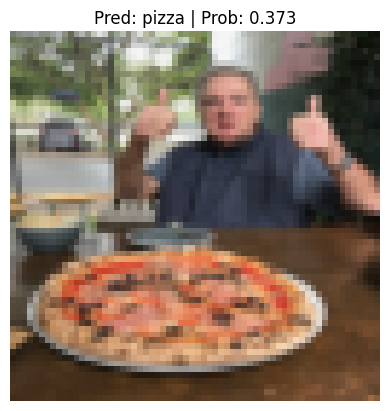

In [ ]:
pred_and_plot_image(model=model_1,
                    image_path=custom_image_path,
                    class_names = class_names,
                    transform = custom_image_transform,
                    device=device)

# The image is pixelated too because we resized it to [64, 64] using custom_image_transform

Main takeaways(핵심 요점 정리)

1. PyTorch has many in-built functions to deal with all kinds of data, from vision to text to audio to recommendation systems

2. If PyTorch's built-in data loading functions don't suit your requirements, you can write code to create your own custom datasets by subclassing torch.utils.data.Dataset
  (PyTorch의 기본 데이터 로딩 기능이 요구사항에 맞지 않다면, torch.utils.data.Dataset을 상속받아 직접 사용자 정의 데이터셋을 만들 수 있음)

3. torch.utils.data.DataLoader's in PyTorch help turn your Dataset's into iterables that can be used when training and testing a model

4. A lot of machine learning is dealing with the balance between overfitting and underfitting (we discussed different methods for each above, so a good exercise would be to research more and writing code to try out the different techniques)

5. Predicting on your own custom data with a trained model is possible, as long as you format the data into a similar format to what the model was trained on
 (1) Wrong datatypes - model expected torch.float32 when your data is torch.uint8.
 (2) Wrong data shapes - model expected [batch_size, color_channels, height, width] when your data is [color_channels, height, width].
 (3) Wrong devices - model is on the GPU but your data is on the CPU